## ECE 579M ST: Machine Learning in Cybersecurity
### Project One: MNIST Classifier

---
## Step 0: Import required packages

In [1]:
## LIST OF ALL IMPORTS
import platform
import os
import csv
import math
import random
import time
import os.path as path

import pickle
import gzip
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from utils import onehot_vectorize,sigmoid_activation,sigmoid_prime

# Visualizations will be shown in the notebook.
%matplotlib inline 

/home/n_srishankar/miniconda3/envs/python2env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
assert platform.python_version()>3, "Need Python2."

---
## Step 1: Load Datasets & Basic Exploration of Dataset

In [3]:
input_data='mnist.pkl.gz'

with gzip.open(input_data,'rb') as f:
    train_raw,valid_raw,test_raw=pickle.load(f)
    
training_images=[np.reshape(x,(784,1)) for x in train_raw[0]]
training_labels=[onehot_vectorize(y) for y in train_raw[1]]
train_data=zip(training_images,training_labels)

valid_images=[np.reshape(x,(784,1)) for x in valid_raw[0]]
valid_labels=valid_raw[1]
valid_data = zip(valid_images,valid_labels)

test_images=[np.reshape(x,(784,1)) for x in test_raw[0]]
test_labels=test_raw[1]
test_data = zip(test_images,test_labels)

print("Loaded MNIST dataset into training-validation-testing datasets.")

Loaded MNIST dataset into training-validation-testing datasets.


### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
## BASIC UNDERSTANDING OF DATASET

# Number of training examples.
n_train=len(train_data)

# Number of validation examples.
n_validation=len(valid_data)

# Number of testing examples.
n_test=len(test_data)

# Shape of an image.
image_shape=train_data[1][0].shape

# Unique classes/labels in the dataset.
n_classes=train_data[1][1].shape

# Further manipulation.
total_sets=n_train+n_validation+n_test
frac_train=n_train/float(total_sets)
frac_valid=n_validation/float(total_sets)
frac_test=n_test/float(total_sets)

print "Number of training examples =", n_train
print "Number of validation examples =", n_validation
print "Number of testing examples =", n_test
print "There are",total_sets, "datasets, split",round(frac_train,2),"-",\
      round(frac_valid,2),"-",round(frac_test,2),"training, validation, and testing respectively."
print "Image data shape =", image_shape
print "Number of classes =", n_classes

Number of training examples = 50000
Number of validation examples = 10000
Number of testing examples = 10000
There are 70000 datasets, split 0.71 - 0.14 - 0.14 training, validation, and testing respectively.
Image data shape = (784, 1)
Number of classes = (10, 1)


#### Visualizing sample training set images

Label  [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


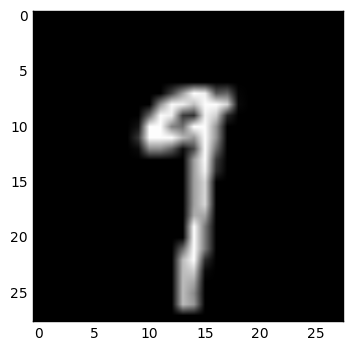

In [5]:
## DATA EXPLORATION & VISUALIZATION
index=np.random.randint(0,n_train)
image=train_data[index][0]
plt.imshow(np.reshape(image,(28,28)),cmap='gray')
print "Label ",train_data[index][1].T

----

## Step 2: Model Architecture

Using simplified architecture described by Michael Nielson

In [6]:
class Model(object):
    def __init__(self,model_size):
        # Model_size=[i,h,o] Input neurons, Hidden neurons, Output neurons
        self.n_layers=len(model_size)
        self.neurons=model_size
        self.weights=[np.random.randn(y,x) for x,y in zip(model_size[:-1],model_size[1:])]
        self.biases=[np.random.randn(y,1) for y in model_size[1:]]
   
    def forward_pass(self,x):
        for weight,bias in zip(self.weights,self.biases):
            x=sigmoid_activation(np.dot(weight,x)+bias)
        
        return x
    
    def new_minibatch(self,minibatch,lr):
        deriv_weight=[np.zeros(weight.shape) for weight in self.weights]
        deriv_bias=[np.zeros(bias.shape) for bias in self.biases]
        
        for x,y in minibatch:
            _,delta_weight,delta_bias=self.backprop(x,y)
            
            deriv_weight=[w+dw for w,dw in zip(deriv_weight,delta_weight)]
            deriv_bias=[b+db for b,db in zip(deriv_bias,delta_bias)]
            
        self.weights=[w-(lr/len(minibatch))*dw for w,dw in zip(self.weights,deriv_weight)]
        self.biases=[b-(lr/len(minibatch))*db for b,db in zip(self.biases,deriv_bias)]

    def gradient_descent(self,n_epochs,minibatch_size,lr,train_data,test_data=None):
        if test_data: 
            n_test=len(test_data)
        n_train=len(train_data)
        
        for epoch in range(n_epochs):
            random.shuffle(train_data)
            minibatches=[train_data[i:i+minibatch_size] for i in range(0,n_train,minibatch_size)]

            for minibatch in minibatches:
                self.new_minibatch(minibatch,lr)

            if test_data:
                print "Epoch {}: Testing accuracy of {}."\
                .format(epoch,float(self.evaluate(test_data))/n_test)
            else:
                print "Epoch {} training complete: Training accuracy of {}."\
                .format(epoch,float(self.evaluate(zip(training_images,train_raw[1])))/n_train)

    def backprop(self,x,y):
        deriv_weight=[np.zeros(weight.shape) for weight in self.weights]
        deriv_bias=[np.zeros(bias.shape) for bias in self.biases]
        
        activation=x
        activations=[x] # All activations
        outputs=[] # All outputs
        
        # Forward Pass
        for weight,bias in zip(self.weights,self.biases):
            output=np.dot(weight,activation)+bias
            outputs.append(output)
            
            activation=sigmoid_activation(output)
            activations.append(activation)
            
        # Backward Pass
        delta=(activations[-1]-y)*sigmoid_prime(outputs[-1]) # Error (y-y') multiplied by gradient
        deriv_weight[-1]=np.dot(delta,activations[-2].transpose())
        deriv_bias[-1]=delta
        
        for i in range(2,self.n_layers):
            output=outputs[-i] # Extract output at a particular layer
            gradient=sigmoid_prime(output)
            delta=np.dot(self.weights[-i+1].transpose(),delta)*gradient
            deriv_weight[-i]=np.dot(delta,activations[-i-1].transpose())
            deriv_bias[-i]=delta
        
        return (delta,deriv_weight,deriv_bias)

    def evaluate(self,data):
        output=[(np.argmax(self.forward_pass(x)),y) for (x,y) in data]
        return sum(int(x == y) for (x, y) in output)

In [7]:
input_neurons=784
hidden_neurons=50
output_neurons=10
n_epochs=30
batch_size=10
learning_rate=2.0

print "Model initialized with {} input neurons, {} hidden neurons, and {} output neurons"\
.format(input_neurons,hidden_neurons,output_neurons)

model=Model([input_neurons,hidden_neurons,output_neurons])

print "Training for {} epochs with a batch size of {} and learning rate of {}."\
.format(n_epochs,batch_size,learning_rate)
model.gradient_descent(n_epochs,batch_size,learning_rate,train_data,None)

Model initialized with 784 input neurons, 50 hidden neurons, and 10 output neurons
Training for 30 epochs with a batch size of 10 and learning rate of 2.0.
Epoch 0 training complete: Training accuracy of 0.81672.
Epoch 1 training complete: Training accuracy of 0.92626.
Epoch 2 training complete: Training accuracy of 0.9397.
Epoch 3 training complete: Training accuracy of 0.94398.
Epoch 4 training complete: Training accuracy of 0.95126.
Epoch 5 training complete: Training accuracy of 0.95518.
Epoch 6 training complete: Training accuracy of 0.95524.
Epoch 7 training complete: Training accuracy of 0.96208.
Epoch 8 training complete: Training accuracy of 0.96426.
Epoch 9 training complete: Training accuracy of 0.96718.
Epoch 10 training complete: Training accuracy of 0.96778.
Epoch 11 training complete: Training accuracy of 0.96832.
Epoch 12 training complete: Training accuracy of 0.97092.
Epoch 13 training complete: Training accuracy of 0.97292.
Epoch 14 training complete: Training accura

In [8]:
print "Training and testing simultaneously."
n_epoch=1
learning_rate=1.0
model.gradient_descent(n_epoch,batch_size,learning_rate,train_data,test_data)

Training and testing simultaneously.
Epoch 0: Testing accuracy of 0.9565.


In [9]:
def Model_evaluate(model,test_image):
    one_hot_output=np.round(model.forward_pass(test_image),2)
    predicted_label=np.argmax(model.forward_pass(test_image))
    return one_hot_output,predicted_label

Actual Label:  6
One-Hot labeling:  [[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
Predicted Label:  6


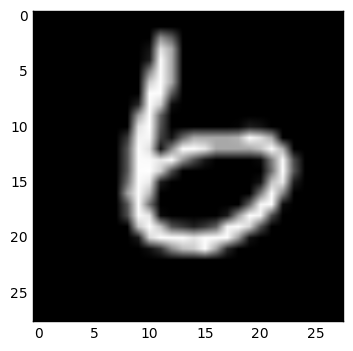

In [10]:
index=np.random.randint(0,n_test)
test_image=test_data[index][0]
plt.imshow(np.reshape(test_image,(28,28)),cmap='gray')
print "Actual Label: ",test_data[index][1]

one_hot_output,predicted_label=Model_evaluate(model,test_image)
print "One-Hot labeling: ",one_hot_output.T
print "Predicted Label: ",predicted_label

---

## Step 3: Adversarial images implementation

In [11]:
def nontargeted_attack(trained_weights,trained_biases,num_layers,image,target_label,descent_steps=10000,descent_stepsize=0.5):
    # Force predicted label to equal target label
    one_hot_target=np.zeros((10,1))
    one_hot_target[target_label]=1
    
    for _ in range(descent_steps):
        delta,deriv_weight,deriv_bias=model.backprop(image,target_label)
        image-=descent_stepsize*(trained_weights[0].T.dot(delta))
    return image

In [12]:
image=np.random.rand(784,1)
num_layers=model.n_layers
target_label=np.random.randint(0,n_classes[0]+1)
weight_values=model.weights
bias_values=model.biases

nontargeted_image=nontargeted_attack(weight_values,bias_values,
                   num_layers,image,target_label,
                   descent_steps=10000,descent_stepsize=0.2)

Target_label is  4 .


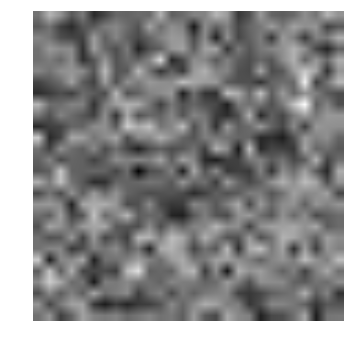

In [13]:
plt.imshow(np.reshape(nontargeted_image,(28,28)),cmap='gray')
plt.axis('off')
print "Target_label is ",target_label,"."
save_title='output_images/Nontargeted_'+str(target_label)
plt.savefig(save_title,bboxes_inches='Tight')

In [14]:
print "Nontargeted image evaluation"

nontarget_adversarial_onehot,nontarget_adversarial_predicted=Model_evaluate(model,nontargeted_image)
print "One-Hot labeling: ",nontarget_adversarial_onehot.T
print "Predicted Label: ",nontarget_adversarial_predicted
# Predicted Label is not equal to the target label  (good attack)

Nontargeted image evaluation
One-Hot labeling:  [[ 0.    0.    1.    0.    0.    1.    0.    0.99  0.98  0.  ]]
Predicted Label:  5


In [15]:
def targeted_attack(trained_weights,trained_biases,num_layers,image,target_image,target_label,descent_steps,descent_stepsize,lambda_reg):
    # Force predicted label to equal target label AND
    # Force output image to equal target image
    one_hot_target=np.zeros((10,1))
    one_hot_target[target_label]=1
    
    for _ in range(descent_steps):
        delta,deriv_bias,deriv_weight=model.backprop(image,target_label)
        image-=descent_stepsize*(trained_weights[0].T.dot(delta)+lambda_reg*(image-target_image))
    return image

In [55]:
image=np.random.rand(784,1)
num_layers=model.n_layers

index=np.random.randint(0,n_test)
target_image=test_data[index][0]
target_label=test_data[index][1]
weight_values=model.weights
bias_values=model.biases

targeted_image=targeted_attack(weight_values,bias_values,
                   num_layers,image,target_image,target_label,
                   descent_steps=10000,descent_stepsize=1.0,lambda_reg=0.1)

Target_label is  9 .


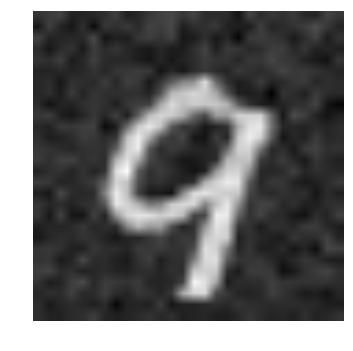

In [56]:
plt.imshow(np.reshape(targeted_image,(28,28)),cmap='gray')
plt.axis('off')
print "Target_label is ",target_label,"."
save_title='output_images/Targeted_'+str(target_label)
plt.savefig(save_title,bboxes_inches='Tight')

In [57]:
print "Targeted image evaluation"

target_adversarial_onehot,target_adversarial_predicted=Model_evaluate(model,targeted_image)
print "One-Hot labeling: ",target_adversarial_onehot.T
print "Predicted Label: ",target_adversarial_predicted
# Predicted Label is not equal to the target label  (good attack)

Targeted image evaluation
One-Hot labeling:  [[ 0.  0.  0.  0.  1.  0.  1.  1.  0.  0.]]
Predicted Label:  4
